In [1]:
import numpy as np
from numpy import nan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import harmonic_mean
from scipy.optimize import minimize
from ast import literal_eval

import sys
sys.path.append("/home/ci411/RapAlignment/")
from rap_align import fma_utils

In [2]:
#import datasets, both pitch countours (fma_large_df) and track data (track_df)

FMA_LARGE_CSV = '/scratch/ci411/rap_data/fma_large_pitchcontour.csv'
fma_large_df = pd.read_csv(FMA_LARGE_CSV).drop(labels='Unnamed: 0', axis=1)
print(fma_large_df.columns)

TRACK_CSV = '/scratch/work/sonyc/marl/private_datasets/FMA/fma_metadata/fma_metadata/tracks.csv'
track_df = fma_utils.load(TRACK_CSV)
track_df = track_df['track']
print(track_df.columns)

RAW_TRACKS_CSV = '/scratch/work/sonyc/marl/private_datasets/FMA/fma_metadata/fma_metadata/raw_tracks.csv'
raw_track_df = pd.read_csv(RAW_TRACKS_CSV)
print(raw_track_df.columns)

Index(['track_id', 'cref_recall', 'cref_false_alarm', 'cref_pitch_acc',
       'cref_chroma_acc', 'cref_overall_acc', 'pref_recall',
       'pref_false_alarm', 'pref_pitch_acc', 'pref_chroma_acc',
       'pref_overall_acc'],
      dtype='object')
Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')
Index(['track_id', 'album_id', 'album_title', 'album_url', 'artist_id',
       'artist_name', 'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', '

In [3]:
len(track_df)

106574

In [4]:
track_df.groupby('license')['number'].count().sort_values(ascending=False)[:25]

license
Attribution-Noncommercial-Share Alike 3.0 United States                            19250
Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International      17732
Attribution-NonCommercial-ShareAlike 3.0 International                             15260
Creative Commons Attribution-NonCommercial-NoDerivatives 4.0                       12133
Attribution-Noncommercial-No Derivative Works 3.0 United States                    10584
Attribution-NonCommercial-ShareAlike                                                6907
Attribution                                                                         4991
Attribution-NonCommercial 3.0 International                                         3570
Attribution-NonCommercial                                                           3409
Attribution-ShareAlike                                                              1549
Attribution-Noncommercial 3.0 United States                                         1036
Creative Comm

In [5]:
#join both datasets on trackid

joined_df = fma_large_df.merge(track_df, on='track_id', how='left')
joined_df = joined_df.merge(raw_track_df, on='track_id', how='left')
print(joined_df.columns)
joined_df.describe()

Index(['track_id', 'cref_recall', 'cref_false_alarm', 'cref_pitch_acc',
       'cref_chroma_acc', 'cref_overall_acc', 'pref_recall',
       'pref_false_alarm', 'pref_pitch_acc', 'pref_chroma_acc',
       'pref_overall_acc', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags_x', 'title',
       'album_id', 'album_title', 'album_url', 'artist_id', 'artist_name',
       'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags_y', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favori

,track_id,cref_recall,cref_false_alarm,cref_pitch_acc,cref_chroma_acc,cref_overall_acc,pref_recall,pref_false_alarm,pref_pitch_acc,pref_chroma_acc,...,artist_id,license_parent_id,track_bit_rate,track_comments,track_disc_number,track_favorites,track_instrumental,track_interest,track_listens,track_number
count,106410.000000,106243.000000,106243.0,106243.000000,106243.000000,106243.000000,105846.000000,105846.0,105846.000000,105846.000000,...,106410.000000,83117.000000,106306.000000,106410.000000,106410.000000,106410.000000,106410.000000,1.064100e+05,106410.000000,106410.000000
mean,79422.851208,0.671718,0.0,0.538631,0.538970,0.538631,0.620318,0.0,0.644978,0.647435,...,12035.740081,5.219558,263663.539574,0.031623,1.012170,3.183629,0.056762,3.541254e+03,2328.809181,8.261893
std,44700.795906,0.250395,0.0,0.235716,0.235579,0.235716,0.252208,0.0,0.199521,0.197190,...,6882.716828,1.354783,66965.110451,0.322170,0.148078,13.521478,0.231388,1.902895e+04,8028.849498,15.252283
min,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,2.000000,192.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000,0.000000
25%,40814.250000,0.561290,0.0,0.405148,0.405748,0.405148,0.472994,0.0,0.536844,0.539404,...,6443.000000,5.000000,192000.000000,0.000000,1.000000,0.000000,0.000000,5.990000e+02,291.000000,2.000000
50%,78835.500000,0.754832,0.0,0.578484,0.578799,0.578484,0.690476,0.0,0.671195,0.672613,...,12030.000000,5.000000,305743.500000,0.000000,1.000000,1.000000,0.000000,1.313500e+03,763.000000,5.000000
75%,119406.750000,0.857043,0.0,0.713374,0.713583,0.713374,0.817916,0.0,0.788583,0.789633,...,18013.000000,6.000000,320000.000000,0.000000,1.000000,3.000000,0.000000,3.060000e+03,2019.000000,9.000000
max,155320.000000,0.999666,0.0,0.999666,0.999666,0.999666,0.999216,0.0,1.000000,1.000000,...,24357.000000,10.000000,448000.000000,37.000000,5.000000,1482.000000,1.000000,3.293557e+06,543252.000000,255.000000


In [6]:
#split genre of each track and extract first (primary) genre
single_genre_df = joined_df.copy().dropna(axis=0, subset=['genre_top'])

#filter down to english-code music
single_genre_df = single_genre_df[single_genre_df['language_code']=='en']

#single_genre_extraction = lambda row : literal_eval(row['track_genres'])[0]['genre_title']
#single_genre_df['primary_track_genre'] = single_genre_df.apply(single_genre_extraction, axis=1)

<AxesSubplot:xlabel='genre_top'>

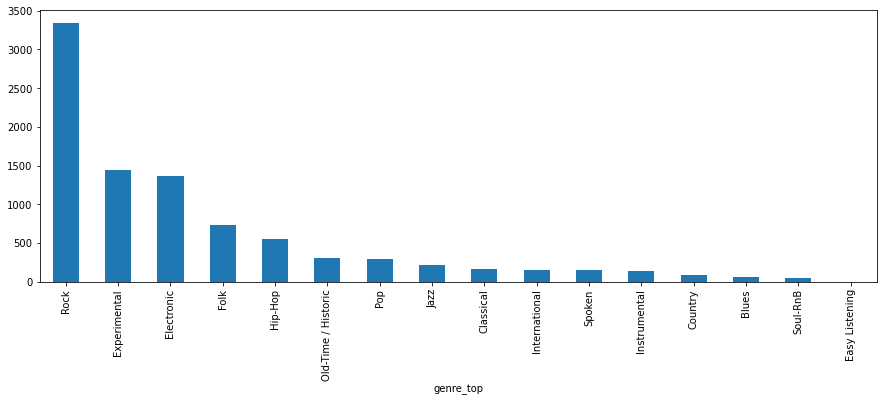

In [7]:
#check genre distribution
fig = plt.figure(figsize=(15,5))
single_genre_df.groupby(by='genre_top')['track_id'].count()\
               .sort_values(ascending=False)[:50].plot.bar()

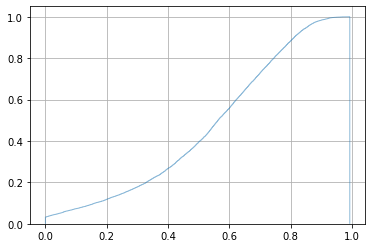

In [8]:
#clone genre-extrated df, take harmonic mean of overall accuracies with pyin/crepe references as sampling func

fma_large_sampling_df = single_genre_df.copy()
selection_func = lambda row:harmonic_mean([row['cref_overall_acc'], row['pref_overall_acc']])
fma_large_sampling_df['harmonic_mean'] = fma_large_sampling_df.apply(selection_func, axis=1)
fma_large_sampling_df['harmonic_mean'].hist(bins=1000, alpha=.5, density=True,\
                                            histtype='step', cumulative=True)

fma_means = fma_large_sampling_df.groupby('genre_top')['harmonic_mean'].mean()
sorted_count_genres = fma_large_sampling_df.groupby('genre_top')['harmonic_mean'].count()\
                                           .sort_values(ascending=False).index.to_list()



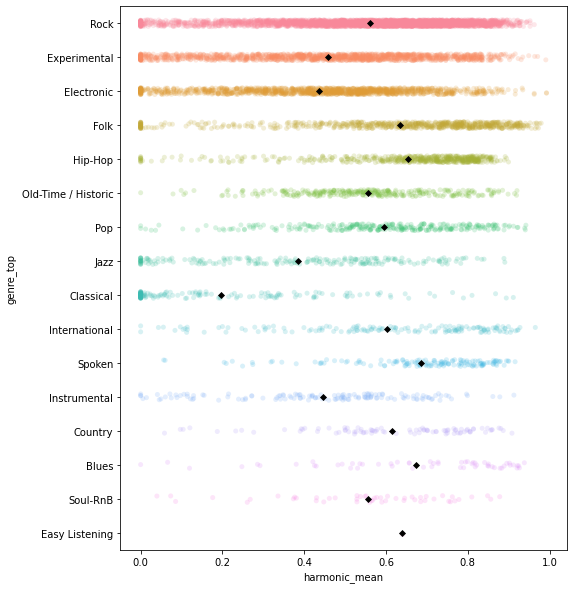

In [13]:
fig = plt.figure(figsize=(8,10))
ax = sns.stripplot(data=fma_large_sampling_df, x="harmonic_mean", y="genre_top", alpha=.2, order=sorted_count_genres)
ax = sns.swarmplot(data=fma_means.to_frame().reset_index(), x="harmonic_mean", y="genre_top", marker="D", color='k', order=sorted_count_genres)
plt.savefig('genre_dist.pdf')

In [46]:
genre_groups = fma_large_sampling_df.groupby('genre_top')
top_samples = pd.DataFrame(columns=fma_large_sampling_df.columns)
n_top = 25
for name, group in genre_groups:
    top_samples = top_samples.append(group.nlargest(n_top, 'harmonic_mean'))
    print(name)
    for row in group.nlargest(n_top, 'harmonic_mean').iterrows():
        print('{} - {}: {}'.format(row[1]['title'], row[1]['artist_name'], row[1]['track_url']))
    print()
    
#print(top_samples.groupby('genre_top')['title', 'track_url'])

Blues
Nothing Really - Brother JT: http://freemusicarchive.org/music/Brother_JT/Live_at_WFMU_on_Brian_Turners_Show_on_5142002/Nothing_Really
The Window - Wildbirds and Peacedrums: http://freemusicarchive.org/music/Wildbirds_and_Peacedrums/Live_at_WFMU_on_Troubles_Show_on_6192008/The_Window
Young But Daily Growing - Brother JT: http://freemusicarchive.org/music/Brother_JT/Live_at_WFMU_on_Brian_Turners_Show_on_5142002/Young_But_Daily_Growing
Laughing to Keep From Cryin' - Kenny Brown: http://freemusicarchive.org/music/Kenny_Brown/Paul_Wine_Jones_T-Model_Ford__Kenny_Brown_Live_at_WFMU_on_David_Suismans_Show_2004/Laughing_to_Keep_From_Cryin
I Can't Tell In His Eyes - Wildbirds and Peacedrums: http://freemusicarchive.org/music/Wildbirds_and_Peacedrums/Live_at_WFMU_on_Troubles_Show_on_6192008/I_Cant_Tell_In_His_Eyes
Hey Mr. Sun - Brother JT: http://freemusicarchive.org/music/Brother_JT/Live_at_WFMU_on_Brian_Turners_Show_on_5142002/Hey_Mr_Sun
Throwaway - Brother JT: http://freemusicarchive.or

In [39]:
top_samples.columns

Index(['track_id', 'cref_recall', 'cref_false_alarm', 'cref_pitch_acc',
       'cref_chroma_acc', 'cref_overall_acc', 'pref_recall',
       'pref_false_alarm', 'pref_pitch_acc', 'pref_chroma_acc',
       'pref_overall_acc', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags_x', 'title',
       'album_id', 'album_title', 'album_url', 'artist_id', 'artist_name',
       'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags_y', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favori

In [38]:
top_samples.groupby('genre_top')['title', 'track_url'].apply(print)

                                            title  \
104624                             Nothing Really   
53545                                  The Window   
32141                     Young But Daily Growing   
64889                Laughing to Keep From Cryin'   
64366                    I Can't Tell In His Eyes   
57234                                 Hey Mr. Sun   
63931                                   Throwaway   
51115                             Hypocrite Shoes   
28473                                 Bittersweet   
8789              Going Down The Road Feeling Bad   
44085                                   Lost Love   
87646                                Now and Then   
44520                            Child of the Sun   
60573                                  Doubt/Hope   
91789                                         SOS   
60786                         Queen of Loneliness   
21019                           There Is No Light   
46665   Nobody Knows You When You're Down and 

/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


""


In [14]:
#def helper functions for defining a linear transform
#into a sigmoid, providing bernoulli probabilities for
#each track

#fit the parameters s.t. the expected number of selected
#tracks is = some N

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def fit_func(data, n):
    def func(params):
        return(np.sqrt(np.power(sum(sigmoid(params[0]*data+params[1]))-n, 2)))
    return func

def bernoulli_sample(df, prob_label='sampling_prob'):
    probs = np.random.rand(len(df))
    return df[df[prob_label]>probs]

def sample_genres(df, n, genres, genre_probs=None, genre_tag='genre_top'):
    if genre_probs is None:
        genre_probs = np.ones(len(genres))
    if sum(genre_probs) != 1:
        genre_probs = genre_probs/sum(genre_probs)
    columns = df.columns
    sample_df = pd.DataFrame(columns=columns)
    for i, genre in enumerate(genres):
        genre_n = n * genre_probs[i]
        genre_df = df[df[genre_tag]==genre]
        func_to_opt = fit_func(genre_df['harmonic_mean'].to_numpy(), genre_n)
        res = minimize(func_to_opt, [1,0], bounds=((0, None), (None, None)))
        sampling_prob = sigmoid(res.x[0]*genre_df['harmonic_mean']+res.x[1]).reindex(genre_df.index)
        genre_df['sampling_prob'] = sampling_prob
        genre_samples = bernoulli_sample(genre_df)
        sample_df = sample_df.append(genre_samples[columns])
    return sample_df
        
        
        

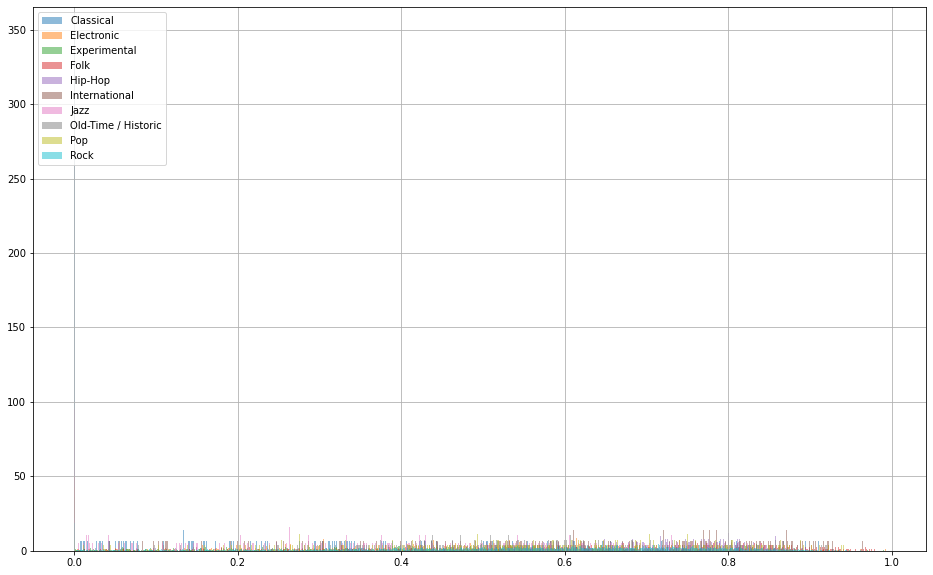

In [15]:
grouped_sample = fma_large_sampling_df.dropna(axis=0, subset=['harmonic_mean'])\
                                      .groupby(by='genre_top')
top_n = 10
top_n_genres = grouped_sample['track_id'].count().sort_values(ascending=False)[:top_n]\
                                         .index.to_list()
bounds = ((0, None), (None, None))
fig = plt.figure(figsize=(16,10))
for name, group in grouped_sample:
    if name in top_n_genres:
        group['harmonic_mean'].hist(bins=1000, alpha=.5, density=True, label=name)#, histtype='step')#, cumulative=True)
        test_func = fit_func(group['harmonic_mean'].to_numpy(), 500)
        res = minimize(test_func, [1,0], bounds=bounds)
        group['sampling_prob'] = sigmoid(res.x[0]*group['harmonic_mean']+res.x[1])
        n_samples = len(bernoulli_sample(group))
        #print("{}, {}, {:.5f}, {:.5f}, {}".format(name, res.x, res.fun, abs_sum, n_samples))
    else:
        continue
plt.legend(loc='upper left')

In [16]:
grouped_sample.describe()

track_id                                                 \
                       count          mean           std      min       25%   
genre_top                                                                     
Blues                   58.0   9789.155172   7626.245922   1042.0   3431.25   
Classical              161.0  13524.496894   3568.596764   4850.0  11345.00   
Country                 91.0  11280.582418   5073.094843   3459.0   4745.50   
Easy Listening           1.0  20695.000000           NaN  20695.0  20695.00   
Electronic            1368.0  12465.629386   7506.665325    384.0   7933.75   
Experimental          1444.0  10680.316482   7069.403203    137.0   4261.75   
Folk                   735.0  10028.918367   8305.990331    139.0   3849.50   
Hip-Hop                552.0  17063.864130  22680.638927      2.0  11778.75   
Instrumental           137.0  17488.562044  18850.479885  10225.0  10272.00   
International          150.0   8686.266667   6212.199882    666.0   4077.25   
Jazz                   212.0  12411.089623   7108.234830    144.0   6639.75   
Old-Time / Historic    303.0  16513.455446   4994.842409   5009.0  16374.50   
Pop                    290.0  14420.727586   7608.021877     10.0   6790.25   
Rock                  3343.0  10485.050553  12909.363623    135.0   3701.50   
Soul-RnB                50.0   4839.320000  13353.586977    734.0    747.25   
Spoken                 147.0   7476.285714   8164.957971    640.0    939.50   

                                                 cref_recall            ...  \
                         50%       75%       max       count      mean  ...   
genre_top                                                               ...   
Blues                 4538.5  19127.50   21800.0        58.0  0.790488  ...   
Classical            11696.0  16949.00   23064.0       161.0  0.215595  ...   
Country              13190.0  14907.50   19229.0        91.0  0.746084  ...   
Easy Listening       20695.0  20695.00   20695.0         1.0  0.682927  ...   
Electronic           13365.5  17497.50   86798.0      1358.0  0.639755  ...   
Experimental          9606.5  17194.25   59401.0      1439.0  0.651079  ...   
Folk                 10484.0  14295.50  111636.0       734.0  0.759872  ...   
Hip-Hop              13591.5  16879.25  152545.0       552.0  0.749563  ...   
Instrumental         11639.0  16528.00  103523.0       137.0  0.627435  ...   
International         6330.0  15487.75   22315.0       150.0  0.723947  ...   
Jazz                 13592.0  18556.25   23082.0       212.0  0.541404  ...   
Old-Time / Historic  18021.0  20133.50   21991.0       302.0  0.826068  ...   
Pop                  18025.0  21405.75   28802.0       290.0  0.749026  ...   
Rock                  8134.0  15297.50  150482.0      3338.0  0.751206  ...   
Soul-RnB               759.5    771.75   86789.0        50.0  0.733025  ...   
Spoken                 976.0  16149.50   29547.0       147.0  0.777053  ...   

                    track_number        harmonic_mean                      \
                             75%    max         count      mean       std   
genre_top                                                                   
Blues                        7.0   22.0          58.0  0.672695  0.233466   
Classical                    3.0   33.0         161.0  0.195703  0.233706   
Country                      8.0   15.0          91.0  0.615551  0.197353   
Easy Listening               3.0    3.0           1.0  0.638173       NaN   
Electronic                   7.0   30.0        1368.0  0.435900  0.219665   
Experimental                10.0  255.0        1444.0  0.457124  0.239513   
Folk                         7.0  100.0         735.0  0.632937  0.247276   
Hip-Hop                     10.0   33.0         552.0  0.654617  0.191286   
Instrumental                 9.0   20.0         137.0  0.446915  0.219661   
International                5.0  100.0         150.0  0.603408  0.244568   
Jazz           

In [17]:
test_genres = ['Electronic', 'Rock', 'Pop', 'Folk', 'Hip-Hop', 'Punk']
test_probs = np.array([1,1,2,3,4,2])
test_n = 1000
test_df = fma_large_sampling_df.dropna(axis=0, subset=['harmonic_mean'])
test_sample = sample_genres(test_df, test_n, test_genres)#), test_probs)

/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

<AxesSubplot:xlabel='genre_top'>

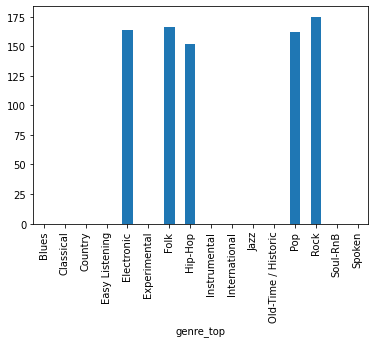

In [18]:
test_sample.groupby(by='genre_top')['track_id'].count().plot.bar()

In [19]:
hip_hop_sample = sample_genres(test_df, 1000, ['Hip-Hop'], np.array([1])).sort_values(by='harmonic_mean', ascending=False)

/scratch/ci411/.conda/envs/rap_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
hip_hop_sample.head(10)[['title','harmonic_mean']]

,title,harmonic_mean
16327,Freestyle,0.899433
76388,Long Term Jammers,0.894652
53035,Come On (Featuring DayMoe),0.891327
74396,Anything is Possible,0.889500
46254,UI Radio 4,0.879691
84620,Looking at my blunt(like the Holy Grail),0.872094
60090,Grown Folklore feat. Willie Evans Jr.,0.870075
56300,Shipwreck (Featuring Zack S. Byer),0.867468
37563,UI Radio 1,0.864979
61381,Cold Nights (Get Your Money Right) (Featuring ...,0.860235


In [21]:
hip_hop_sample.head(10)['track_url'].to_list()

['http://freemusicarchive.org/music/Yung_Nittlz/Live_at_WFMU_on_Billy_Jams_Show_52209_1351/Freestyle',
 'http://freemusicarchive.org/music/The_Years/vosotros_presents_the_years__mixtape/Long_Term_Jammers',
 'http://freemusicarchive.org/music/CM_aka_Creative/Classic_Material_Vol_3_UI_Radio/Come_On_Featuring_DayMoe',
 'http://freemusicarchive.org/music/CM_aka_Creative/Classic_Material_Vol_3_UI_Radio/Anything_is_Possible',
 'http://freemusicarchive.org/music/CM_aka_Creative/Classic_Material_Vol_3_UI_Radio/UI_Radio_4',
 'http://freemusicarchive.org/music/Yshwa/Melody_Ln/12_looking_at_my_bluntlike_the_Holy_Grail',
 'http://freemusicarchive.org/music/Eddie_Meeks/After_This_Ill_Holla_On_Everythang_I_Love/Grown_Folklore_feat_Willie_Evans_Jr',
 'http://freemusicarchive.org/music/Formula/The_Overcast_Project/02_-_Shipwreck_Featuring_Zack_S_Byermp3',
 'http://freemusicarchive.org/music/CM_aka_Creative/Classic_Material_Vol_3_UI_Radio/UI_Radio_1',
 'http://freemusicarchive.org/music/CM_aka_Creative